In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

C:\Users\jamie\AppData\Local\Temp\ipykernel_4116\1327219338.py:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)
c:\Users\jamie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jamie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\jamie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
c:\Users\jamie\AppData\Local\Program

Epoch 1/25
338/338 ━━━━━━━━━━━━━━━━━━━━ 87s 224ms/step - accuracy: 0.2231 - loss: 2.7146 - val_accuracy: 0.6058 - val_loss: 1.3504
Epoch 2/25
338/338 ━━━━━━━━━━━━━━━━━━━━ 73s 216ms/step - accuracy: 0.5343 - loss: 1.4999 - val_accuracy: 0.7005 - val_loss: 0.9802
Epoch 3/25
338/338 ━━━━━━━━━━━━━━━━━━━━ 79s 233ms/step - accuracy: 0.6201 - loss: 1.2086 - val_accuracy: 0.7371 - val_loss: 0.8190
Epoch 4/25
338/338 ━━━━━━━━━━━━━━━━━━━━ 803s 2s/step - accuracy: 0.6650 - loss: 1.0474 - val_accuracy: 0.7631 - val_loss: 0.7103
Epoch 5/25
338/338 ━━━━━━━━━━━━━━━━━━━━ 61s 179ms/step - accuracy: 0.7010 - loss: 0.9300 - val_accuracy: 0.7840 - val_loss: 0.6449
Epoch 6/25
338/338 ━━━━━━━━━━━━━━━━━━━━ 60s 176ms/step - accuracy: 0.7220 - loss: 0.8535 - val_accuracy: 0.8073 - val_loss: 0.5784
Epoch 7/25
338/338 ━━━━━━━━━━━━━━━━━━━━ 59s 175ms/step - accuracy: 0.7417 - loss: 0.7734 - val_accuracy: 0.8207 - val_loss: 0.5361
Epoch 8/25
338/338 ━━━━━━━━━━━━━━━━━━━━ 60s 177ms/step - accuracy: 0.7553 - loss: 0.7

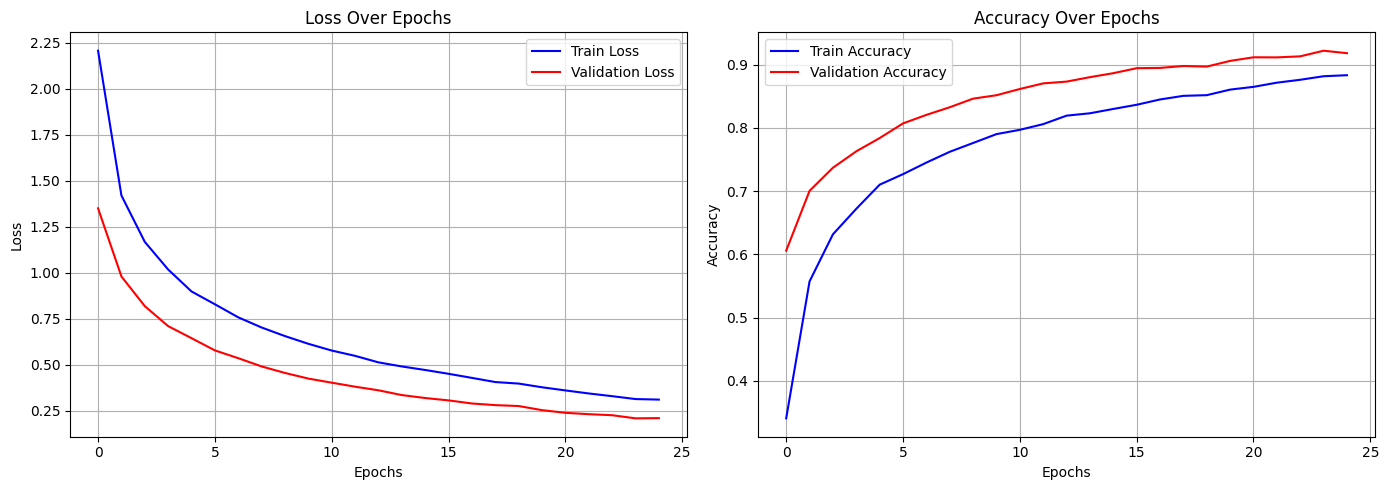

225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step
Classification Report:
                precision    recall  f1-score   support

   Brush_teeth       0.97      1.00      0.99       439
  Climb_stairs       0.73      0.85      0.78       471
     Comb_hair       1.00      1.00      1.00       450
Descend_stairs       0.95      0.99      0.97       496
   Drink_glass       0.99      0.98      0.99       449
      Eat_meat       0.97      0.99      0.98       450
      Eat_soup       0.98      1.00      0.99       455
     Getup_bed       0.98      0.95      0.96       416
   Liedown_bed       0.97      1.00      0.99       445
        Normal       0.85      0.51      0.64       437
    Pour_water       0.96      1.00      0.98       432
       Seizure       0.70      0.88      0.78       458
 Sitdown_chair       0.97      0.99      0.98       456
 Standup_chair       0.97      0.99      0.98       445
 Use_telephone       1.00      1.00      1.00       451
          Walk       0.81      0.63   

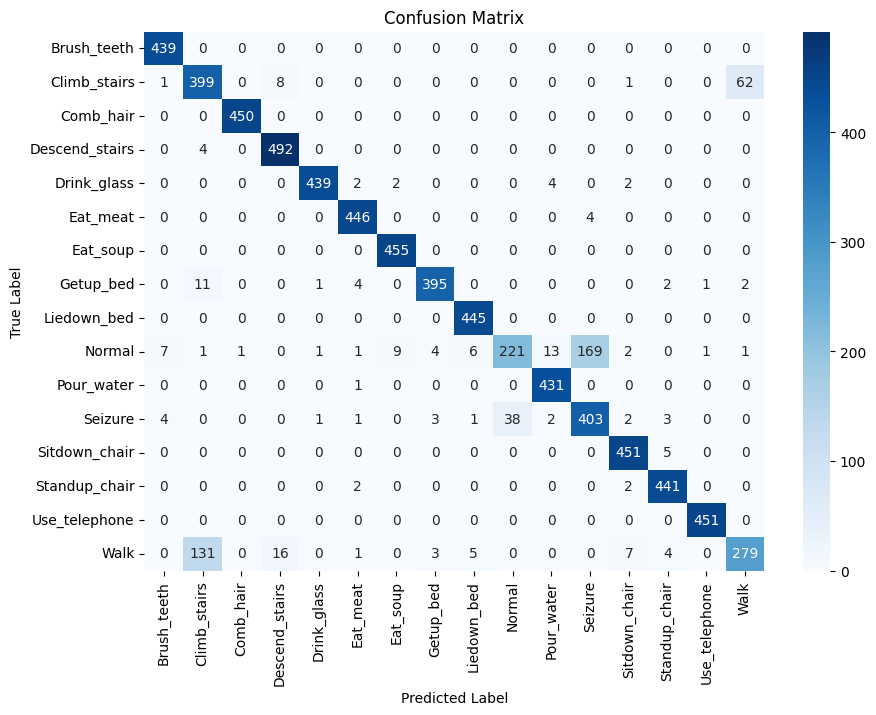

In [ ]:
# Load the dataset
data_path = "../Datasets/activity_seizure_dataset.csv"
df = pd.read_csv(data_path)

# Define timestep size
timestep_size = 125  # Each timestep consists of 125 rows

# Prepare sequences
x_data, y_data = [], []

for event_id, event_data in df.groupby("eventId"):
    sequences = event_data[["x", "y", "z", "magnitude" ]].values
    labels = event_data["label"].values
    
    # Split into 125-row timesteps
    for i in range(0, len(sequences) - timestep_size + 1, timestep_size):
        x_data.append(sequences[i:i + timestep_size])
        y_data.append(labels[i])  # Assign the first label in the segment

x_data = np.array(x_data)  # Shape: (num_timesteps, 125, 4)
y_data = np.array(y_data)

# Encode labels
label_encoder = LabelEncoder()
y_data_encoded = label_encoder.fit_transform(y_data)
y_data_encoded = to_categorical(y_data_encoded, num_classes=len(label_encoder.classes_))

# Reshape for oversampling
x_data_reshaped = x_data.reshape(x_data.shape[0], -1)

# Apply random oversampling
ros = RandomOverSampler(random_state=42)
x_resampled, y_resampled = ros.fit_resample(x_data_reshaped, np.argmax(y_data_encoded, axis=1))

# Reshape back to original format
x_resampled = x_resampled.reshape(-1, timestep_size, 4)
y_resampled = to_categorical(y_resampled, num_classes=len(label_encoder.classes_))

# Split the dataset
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.25, random_state=333)

# Build the LSTM model
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(timestep_size, 4)),
    BatchNormalization(),
    Dropout(0.2),

    Bidirectional(LSTM(64, return_sequences=False)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train with Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('../Models/Early_Stopping/best_model.keras', save_best_only=True)

history = model.fit(x_train, y_train, epochs=25, batch_size=64, validation_data=(x_test, y_test), 
                    callbacks=[early_stopping, model_checkpoint])

# Evaluate the model
score = model.evaluate(x_test, y_test, verbose=1)
print(f'Test loss: {score[0]}')
print(f'Test accuracy: {score[1]}')

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(history.history['loss'], label='Train Loss', color='blue')
axes[0].plot(history.history['val_loss'], label='Validation Loss', color='red')
axes[0].set_title('Loss Over Epochs')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].grid(True)
axes[0].legend()

axes[1].plot(history.history['accuracy'], label='Train Accuracy', color='blue')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axes[1].set_title('Accuracy Over Epochs')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

# Predictions
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

model.save('../Models/osdb_activity_model.keras')


In [ ]:
import pandas as pd

path = "../Datasets/seizure_data.csv"
df = pd.read_csv(path)

# Assuming your original DataFrame is called df
df1 = df.iloc[0:104125]  # Select rows from index 0 to 104126 (inclusive of 0, exclusive of 104127)

df1.to_csv("../Datasets/sample_osdb_data.csv")

df1.tail()


,eventId,Id,userId,x,y,z,magnitude,label
104120,14159,2116,45,0.0,0.0,0.0,1537.0,Seizure
104121,14159,2117,45,0.0,0.0,0.0,1555.0,Seizure
104122,14159,2118,45,0.0,0.0,0.0,1556.0,Seizure
104123,14159,2119,45,0.0,0.0,0.0,1555.0,Seizure
104124,14159,2120,45,0.0,0.0,0.0,1565.0,Seizure


In [ ]:
path = "../Datasets/downsampled_activity_dataset.csv"
df2 = pd.read_csv(path)
# Assuming your dataframe is called df
df2 = df[['eventId', 'Id', 'userId', 'x', 'y', 'z', 'magnitude', 'label']]
df2.to_csv("..Datasets/activity_dataset.csv")
df2.head()

,eventId,Id,userId,x,y,z,magnitude,label
0,6897,206,39,332.0,912.0,-560.0,1120.521362,Seizure
1,6897,207,39,156.0,756.0,-460.0,898.594482,Seizure
2,6897,208,39,220.0,828.0,-420.0,954.140442,Seizure
3,6897,209,39,236.0,908.0,-452.0,1041.375977,Seizure
4,6897,210,39,256.0,840.0,-516.0,1018.524414,Seizure


In [34]:
# Step 1: Drop the 'Id' column
df1 = df1.drop(columns=['Id'])
df2 = df2.drop(columns=['Id'])

# Step 2: Concatenate the dataframes
df_combined = pd.concat([df1, df2], ignore_index=True)

# Step 3: Add 'Id' column back (starting from 1)
df_combined['Id'] = df_combined.index + 1
df = df_combined[['eventId', 'Id', 'userId', 'x', 'y', 'z', 'magnitude', 'label']]


In [35]:
df.head()

,eventId,Id,userId,x,y,z,magnitude,label
0,6897,1,39,332.0,912.0,-560.0,1120.521362,Seizure
1,6897,2,39,156.0,756.0,-460.0,898.594482,Seizure
2,6897,3,39,220.0,828.0,-420.0,954.140442,Seizure
3,6897,4,39,236.0,908.0,-452.0,1041.375977,Seizure
4,6897,5,39,256.0,840.0,-516.0,1018.524414,Seizure
